## Vision Transformer Embeddings

> [!NOTE]
> 1. For each patch, the patch is pushed through a linear operator, to obtain a vector ("patch embedding"). 
> 2. The position of the patch is also transformed into a vector by "position encoding".
> 3. The two vectors are added, then pushed through several Transformer encoders.

/Users/deburky/Documents/python/llm-rag/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


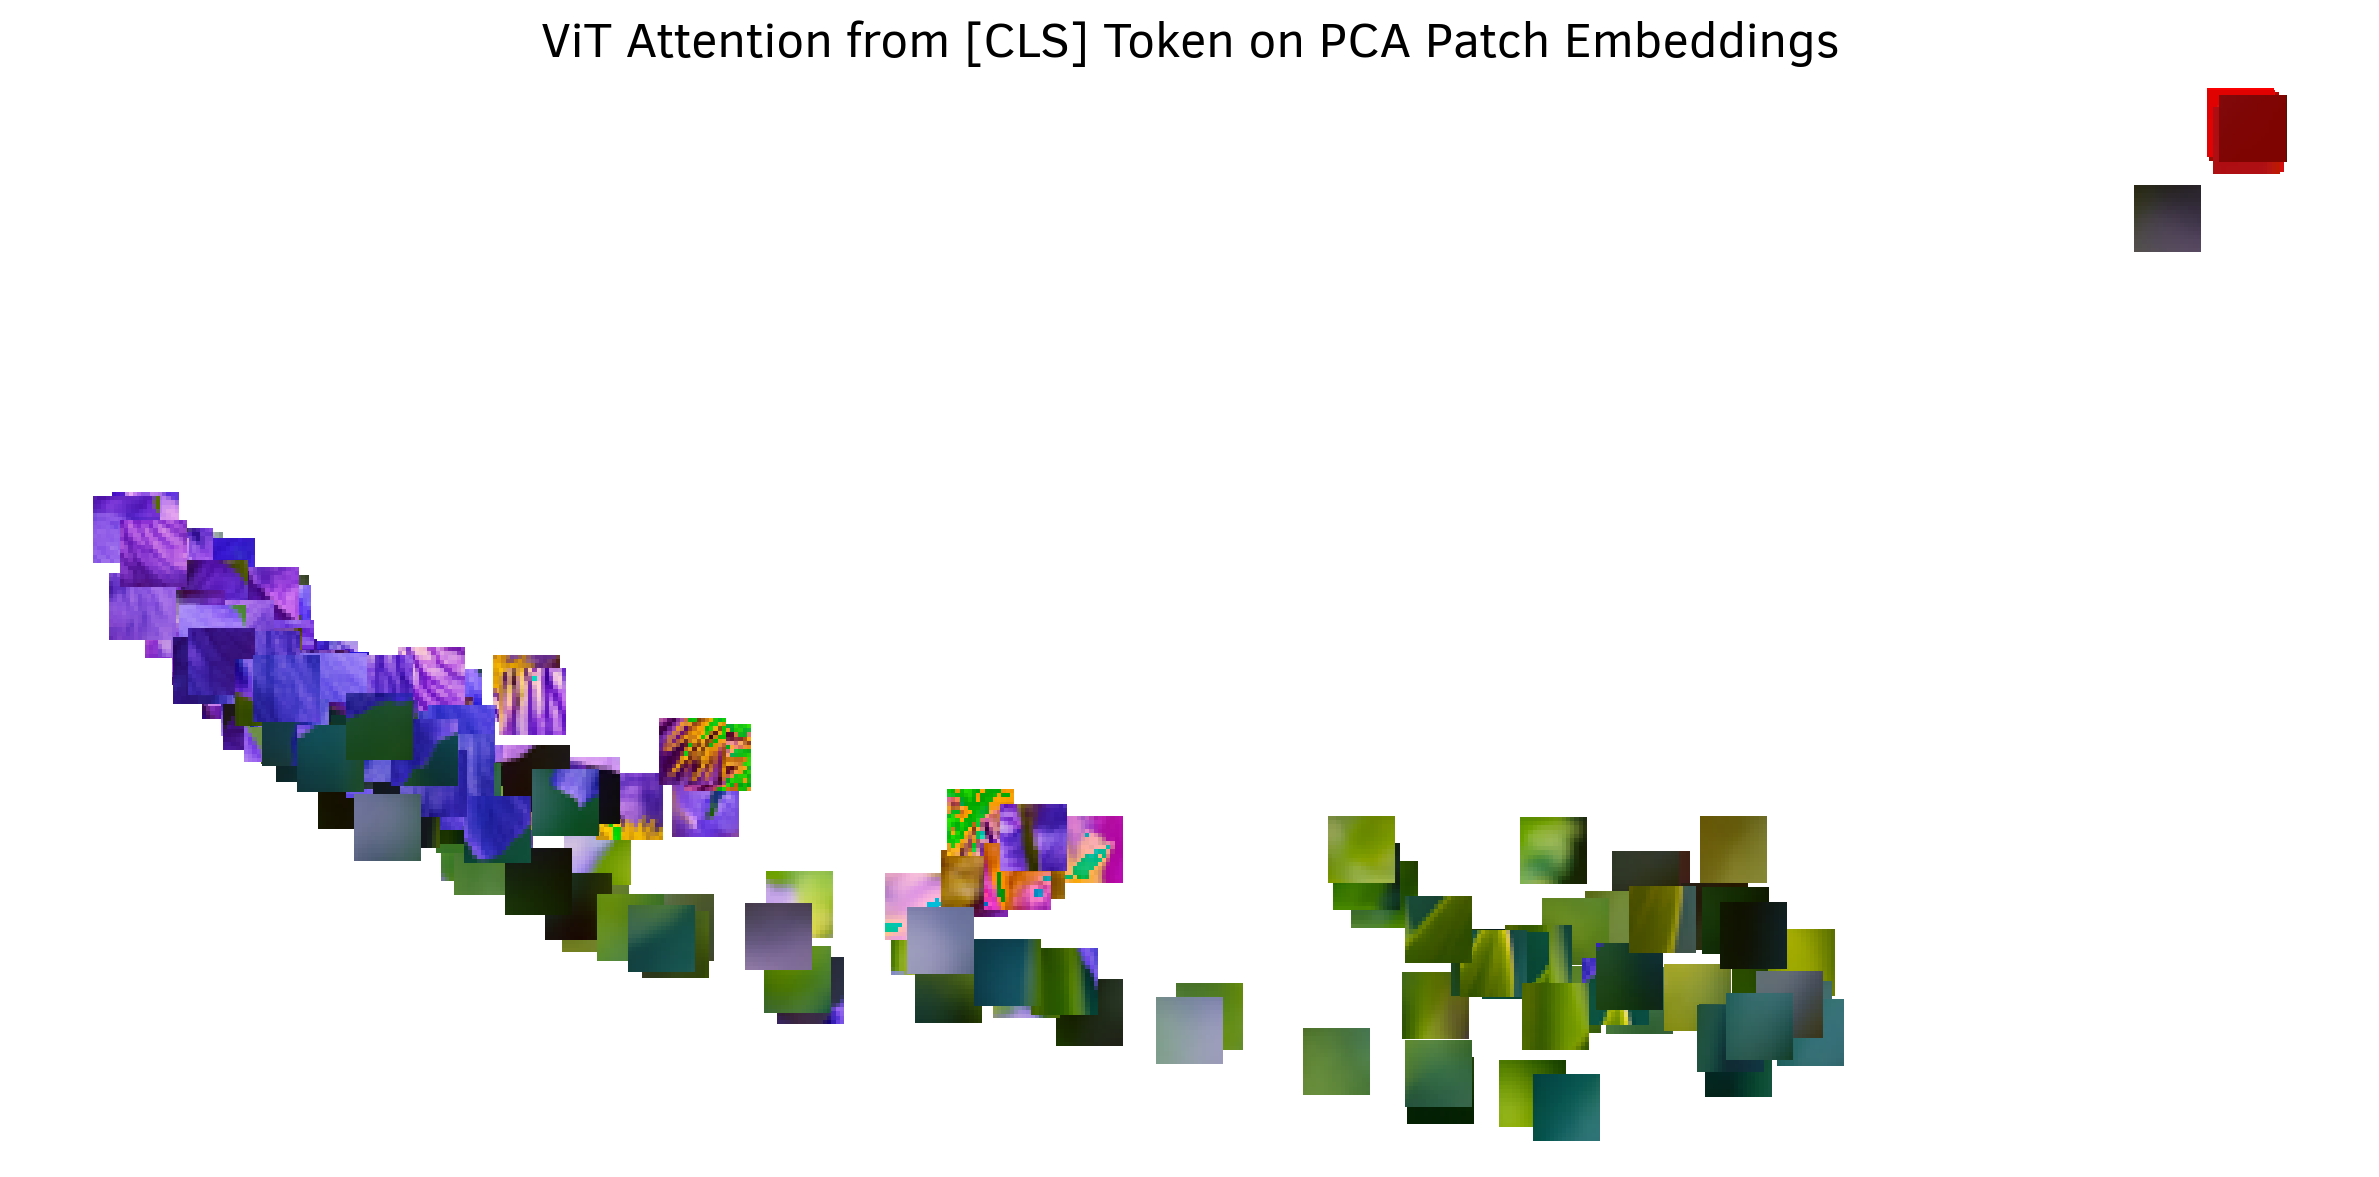

In [ ]:
import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel

# #4c4dff
# Use dark background for plots
BACKGROUND_COLOR = "#ffffff"
# plt.style.use("dark_background")
plt.rcParams["figure.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.facecolor"] = BACKGROUND_COLOR


# Config
IMAGE_PATH = "../images/image.png"
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = (
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)
COLOR_SPACE = "RGB"  # Image color space

# Load image and model
image = Image.open(IMAGE_PATH).convert(COLOR_SPACE).resize((224, 224))
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE)
model.eval()

# Process image and get model outputs
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

# Extract [CLS] token and patch tokens
tokens = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # shape: (197, 768)

# --- PCA projection ---
proj = PCA(n_components=2).fit_transform(tokens)
patch_proj = proj[1:]  # exclude [CLS]

# Extract attention weights
attn = outputs.attentions[-1][0, :, 0, 1:]  # shape: (heads, 196)
attn_mean = attn.mean(0).cpu().numpy()  # shape: (196,)
attn_norm = (attn_mean - attn_mean.min()) / (attn_mean.max() - attn_mean.min() + 1e-8)

# Image preparation
image_resized = image.resize((224, 224))  # Match ViT input
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(len(patch_proj))]

# Plotting
plt.rcParams["font.family"] = "Clear Sans"
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.set_title("ViT Attention from [CLS] Token on PCA Patch Embeddings", fontsize=18)
ax.scatter(patch_proj[:, 0], patch_proj[:, 1], c="lightgray", alpha=0.3)

# Overlay patches with attention weights
for idx in range(len(patch_proj)):
    row, col = coords[idx]
    x = col * patch_size
    y = row * patch_size
    patch = image_resized.crop((x, y, x + patch_size, y + patch_size))

    # Apply red tint based on attention weight
    patch_np = np.array(patch).astype(np.float32) / 255.0
    alpha = attn_norm[idx]  # [0, 1]
    red_overlay = np.array([5.0, 0.0, 0.0])
    tinted = (1 - alpha) * patch_np + alpha * red_overlay
    tinted_patch = Image.fromarray((tinted * 255).astype(np.uint8))

    imagebox = OffsetImage(tinted_patch, zoom=1.5)
    ab = AnnotationBbox(imagebox, (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False)
    ax.add_artist(ab)

# fig.patch.set_edgecolor('white')
# fig.patch.set_linewidth(10)

plt.axis("off")
plt.tight_layout()
plt.show()

## Embeddings

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


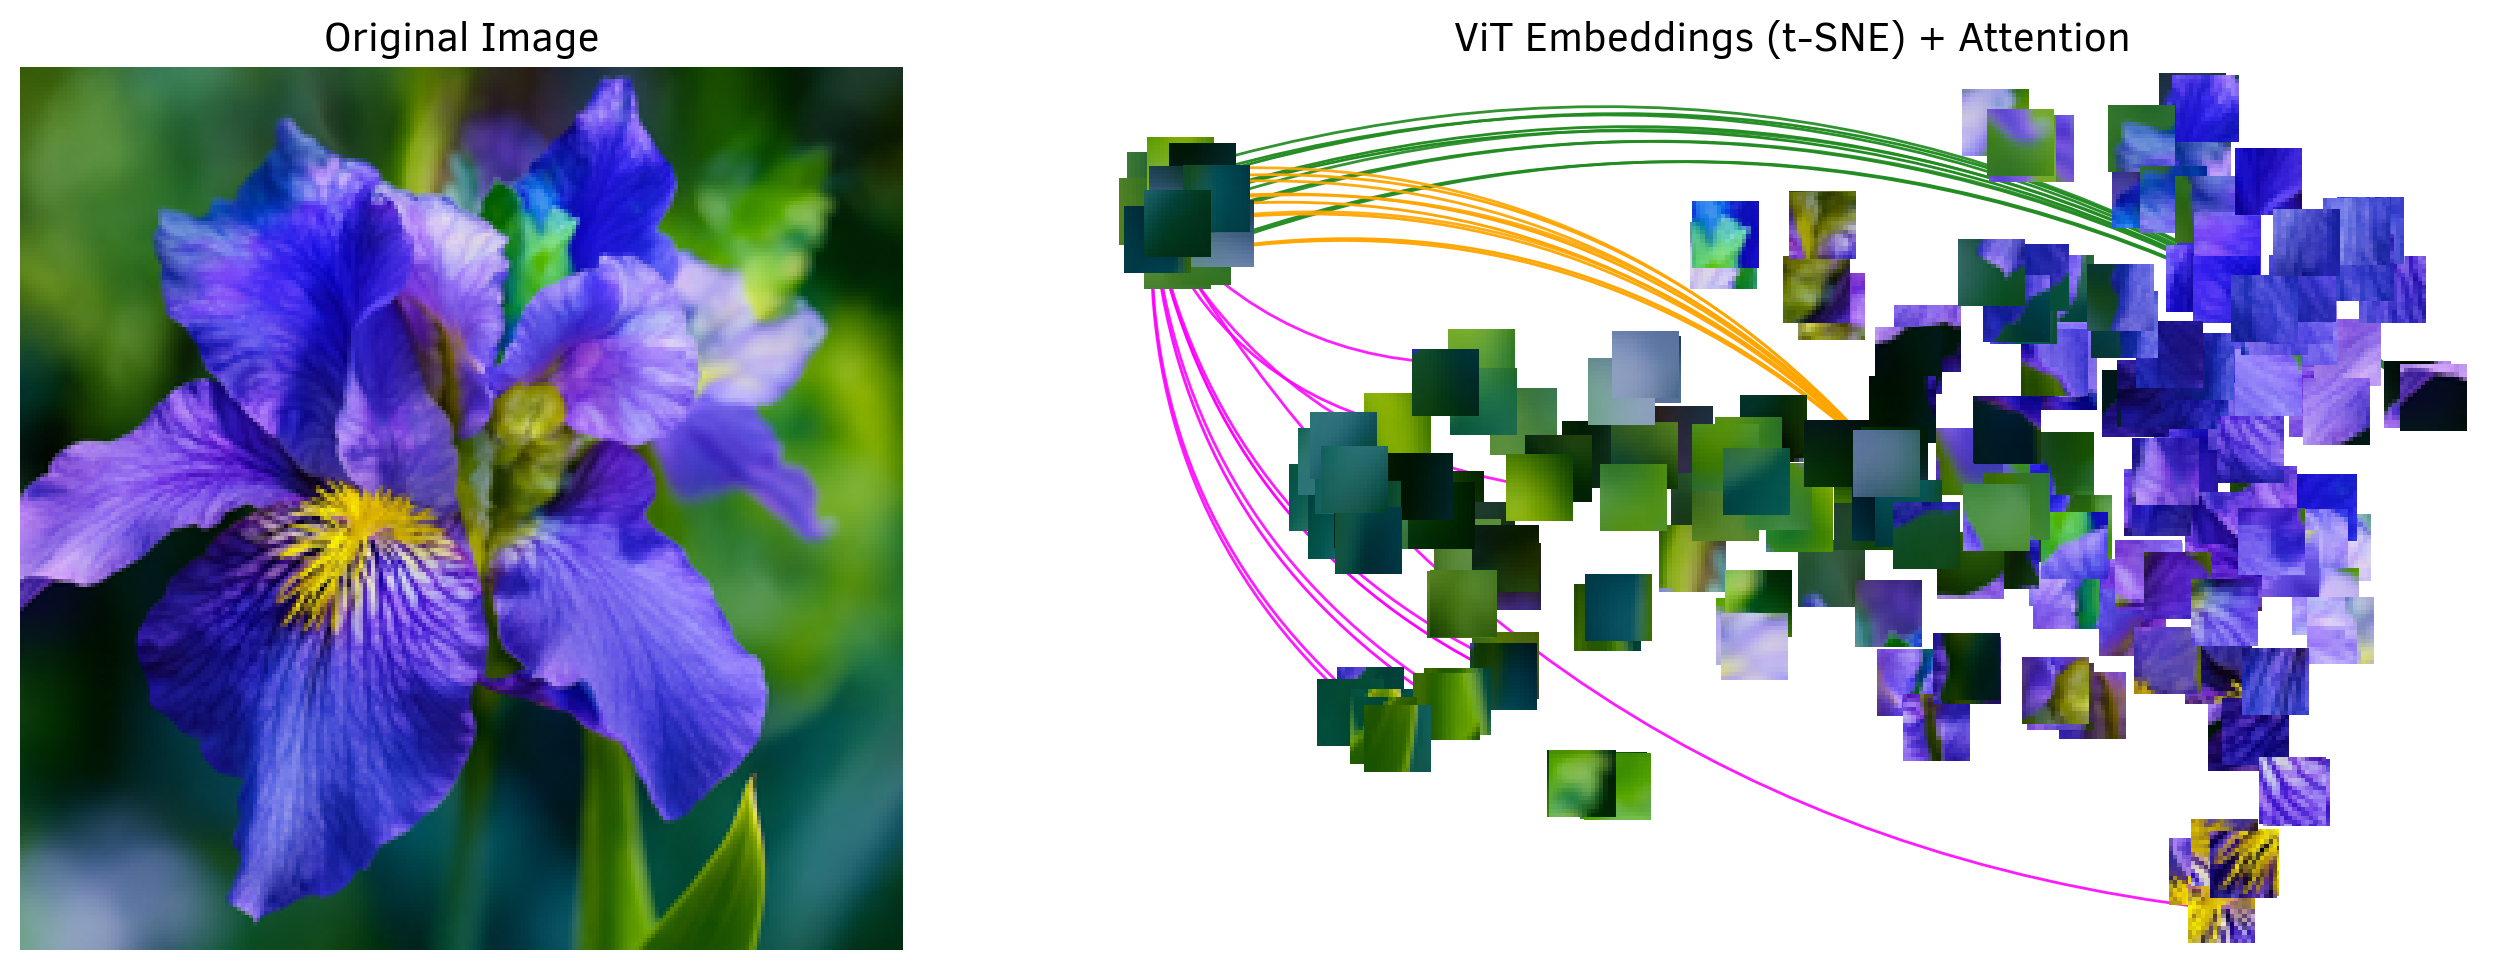

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.patches import FancyArrowPatch
from sklearn.manifold import TSNE
from transformers import ViTImageProcessor, ViTModel

# Config
IMAGE_PATH = "../images/image.png"
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = (
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)
COLOR_SPACE = "RGB"  # Image color space

# Load image and model
image = Image.open(IMAGE_PATH).convert(COLOR_SPACE).resize((224, 224))
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True, output_hidden_states=True).to(
    DEVICE
)
model.eval()

# Forward pass
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)


# Arrow drawing function
def draw_attention_from(src_idx, color="crimson", label="", top_k: int = 10, number: int = None):
    src_proj = patch_proj[src_idx]
    attn = outputs.attentions[-1][0, :, src_idx + 1, 1:]  # heads × 196
    attn_mean = attn.mean(0).cpu().numpy()
    attn_norm = (attn_mean - attn_mean.min()) / (attn_mean.max() - attn_mean.min() + 1e-8)
    topk_idx = np.argsort(attn_mean)[-top_k:]

    for idx in topk_idx:
        if idx == src_idx:
            continue
        dest = patch_proj[idx]
        arrow = FancyArrowPatch(
            posA=src_proj,
            posB=dest,
            arrowstyle="->",
            color=color,
            linewidth=1.0,
            alpha=attn_norm[idx],
            connectionstyle="arc3,rad=0.25",
        )
        ax2.add_artist(arrow)


# Output patches
def output_patches(outputs, type="last_hidden_state"):
    if type == "last_hidden_state":
        tokens = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # (197, 768)
        return tokens[1:]
    elif type == "pos":
        return model.embeddings.position_embeddings[0, 1:].detach().cpu().numpy()
    elif type == "patch":
        patch_embeds = model.embeddings.patch_embeddings(inputs["pixel_values"])
        return patch_embeds.squeeze(0).cpu().detach().numpy()  # shape (196, hidden_dim)
    elif type == "patch_plus_pos":
        patch_embeds = model.embeddings.patch_embeddings(inputs["pixel_values"])
        pos_embed = model.embeddings.position_embeddings[:, 1:, :]
        full_input = patch_embeds + pos_embed
        return full_input.squeeze(0).cpu().detach().numpy()  # shape (196, hidden_dim)
    else:
        raise ValueError(
            "Invalid type. Use 'last_hidden_state', 'pos', 'patch', or 'patch_and_pos'."
        )


patch_tokens = output_patches(outputs, type="last_hidden_state")  # shape (196, 768)

tsne_config = {
    "n_components": 2,
    "perplexity": 30,
    "learning_rate": 100,
    "random_state": 42,
}

# t-SNE projection
tsne = TSNE(**tsne_config)
patch_proj = tsne.fit_transform(patch_tokens)  # shape (196, 2)

# Patch coordinates
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(len(patch_proj))]
image_resized = image.resize((224, 224))

# Normalize norms for color mapping
norms = np.linalg.norm(patch_tokens, axis=1)
norms = (norms - norms.min()) / (norms.max() - norms.min())

# Plotting
plt.rcParams["font.family"] = "Clear Sans"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

ax1.imshow(image_resized)
ax1.axis("off")
ax1.set_title("Original Image", fontsize=15)

ax2.set_title("ViT Embeddings (t-SNE) + Attention", fontsize=15)
ax2.scatter(patch_proj[:, 0], patch_proj[:, 1], c=norms, cmap="viridis", alpha=0.4)

# Add patch thumbnails
for idx in range(len(patch_proj)):
    row, col = coords[idx]
    x, y = col * patch_size, row * patch_size
    patch = image_resized.crop((x, y, x + patch_size, y + patch_size))
    ab = AnnotationBbox(
        OffsetImage(patch, zoom=1.5), (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False
    )
    ax2.add_artist(ab)


# Select and draw attention arrows
left_idx = patch_proj[:, 0].argmin()
right_idx = patch_proj[:, 0].argmax()
center_idx = np.linalg.norm(patch_proj - patch_proj.mean(0), axis=1).argmin()

draw_attention_from(left_idx, color="fuchsia", label="Leftmost", number=1)
draw_attention_from(right_idx, color="forestgreen", label="Rightmost", number=2)
draw_attention_from(center_idx, color="orange", label="Central", number=3)

# fig.patch.set_edgecolor('white')
# fig.patch.set_linewidth(10)

ax2.axis("off")
# ax2.invert_yaxis()
plt.tight_layout()
plt.savefig(
    "../images/vit_attention_tsne.png", dpi=600, bbox_inches="tight", facecolor=BACKGROUND_COLOR
)
plt.show()

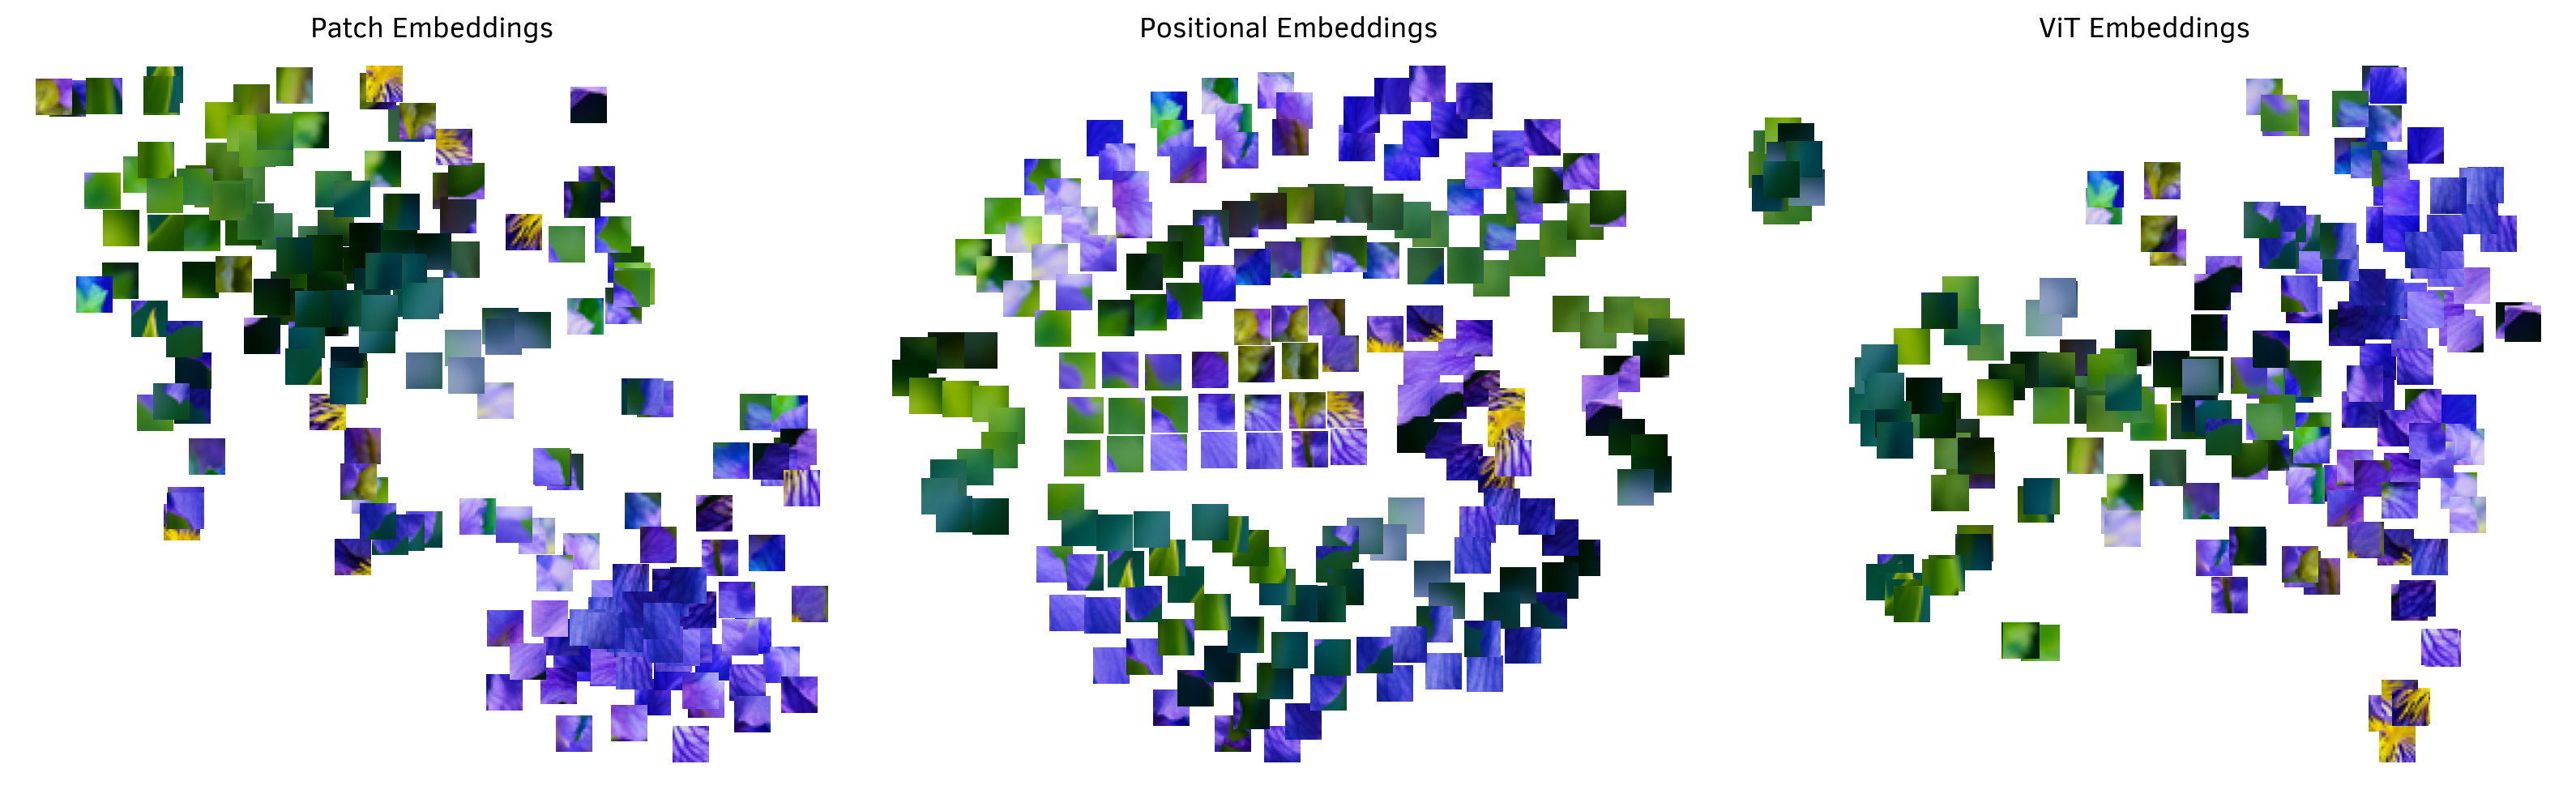

In [ ]:
types = ["patch", "pos", "last_hidden_state"]
titles = ["Patch Embeddings", "Positional Embeddings", "ViT Embeddings"]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=200)

for i, ax in enumerate(axes):
    t = types[i]
    if t == "patch":
        patch_tokens = output_patches(outputs, type="patch")
    elif t == "pos":
        patch_tokens = output_patches(outputs, type="pos")
    else:
        patch_tokens = output_patches(outputs, type="last_hidden_state")

    tsne = TSNE(**tsne_config)
    patch_proj = tsne.fit_transform(patch_tokens)

    norms = np.linalg.norm(patch_tokens, axis=1)
    norms = (norms - norms.min()) / (norms.max() - norms.min())

    ax.set_title(titles[i], fontsize=13)
    ax.scatter(patch_proj[:, 0], patch_proj[:, 1], c=norms, cmap="viridis", alpha=0.4)
    ax.axis("off")

    for idx in range(len(patch_proj)):
        row, col = coords[idx]
        x, y = col * patch_size, row * patch_size
        patch = image_resized.crop((x, y, x + patch_size, y + patch_size))
        ab = AnnotationBbox(
            OffsetImage(patch, zoom=1.0), (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False
        )
        ax.add_artist(ab)

plt.tight_layout()
plt.savefig(
    "../images/vit_attention_tsne_types.png",
    dpi=600,
    bbox_inches="tight",
    facecolor=BACKGROUND_COLOR,
)
plt.show()

## Embedding similarity

In [7]:
import torch
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel

# Load model and processor
model = ViTModel.from_pretrained("google/vit-base-patch16-224").eval()
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

IMAGE_PATH = "../images/image.png"
IMAGE_PATH2 = "../images/image_2.jpeg"

# Load and preprocess two images
image1 = Image.open(IMAGE_PATH).convert("RGB").resize((224, 224))
image2 = Image.open(IMAGE_PATH2).convert("RGB").resize((224, 224))
inputs = processor(images=[image1, image2], return_tensors="pt")

# Extract [CLS] embeddings
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # (2, 768)

# Compute cosine similarity
similarity = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))
print(f"Similarity: {similarity.item():.4f}")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similarity: 0.6893


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


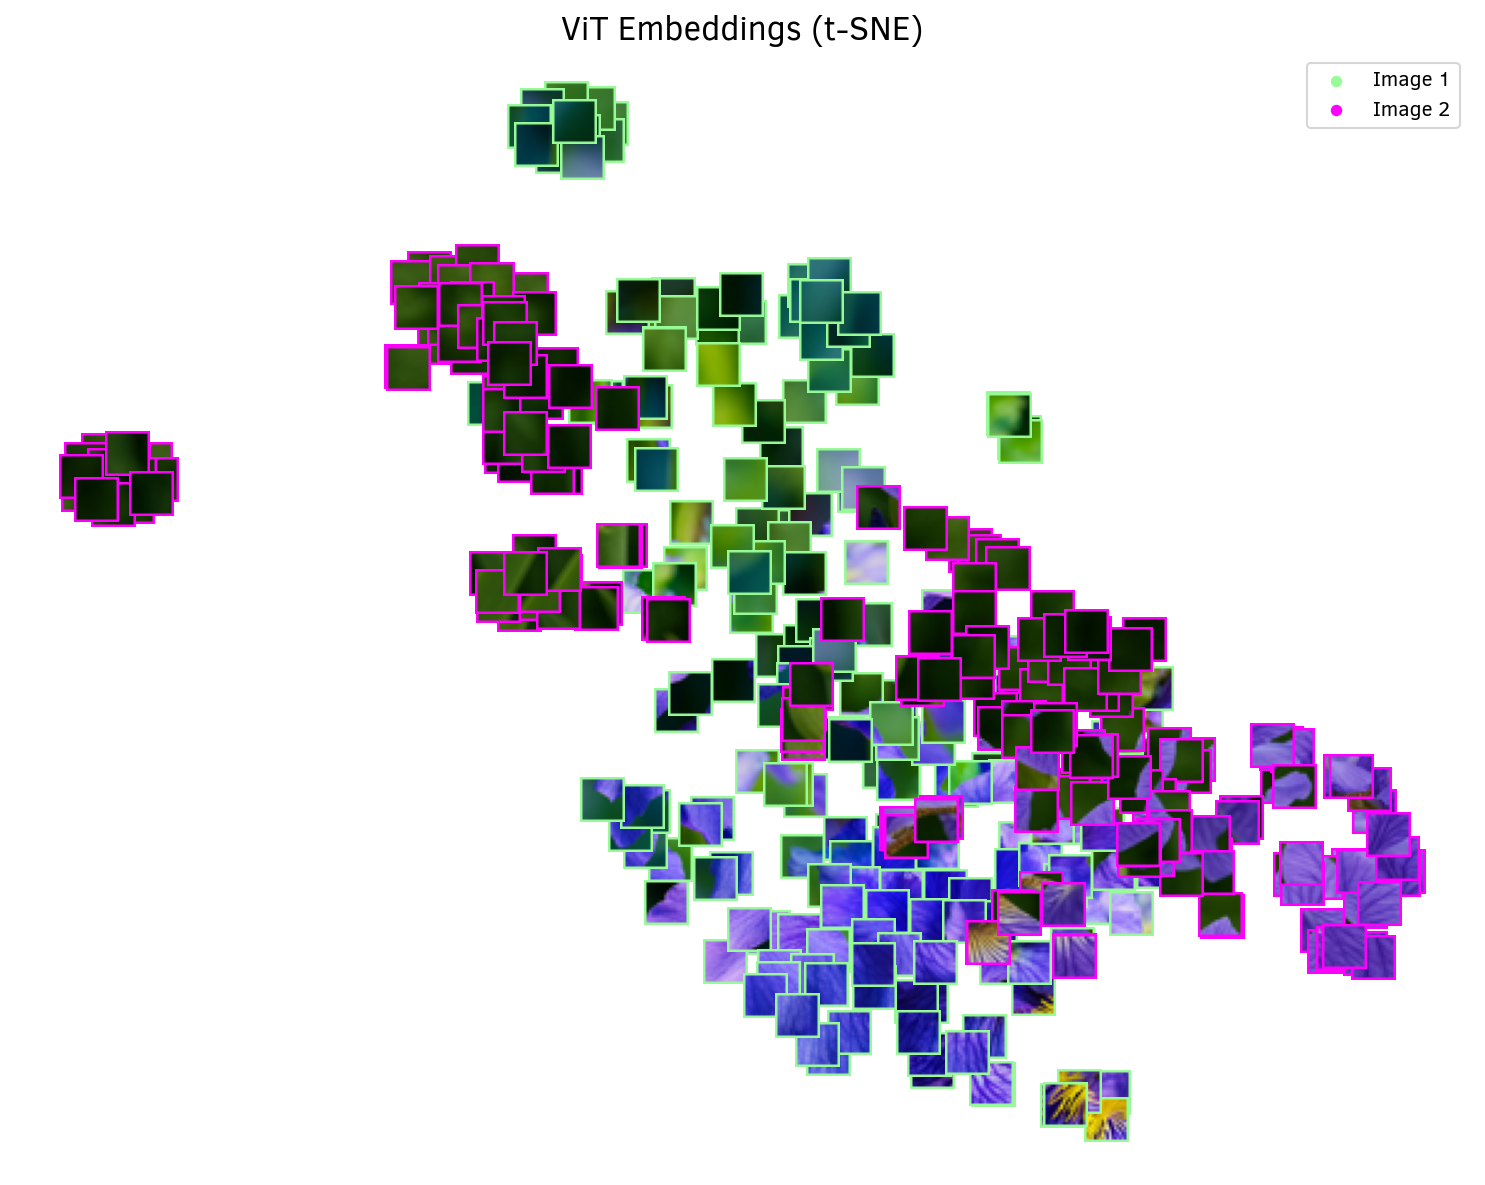

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image, ImageOps
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.manifold import TSNE
from transformers import ViTImageProcessor, ViTModel

# Config
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = torch.device("mps" if torch.cuda.is_available() else "cpu")
IMAGE_PATH1 = "../images/image.png"
IMAGE_PATH2 = "../images/image_2.png"

# Load model and processor
model = ViTModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

# Load and preprocess images
img1 = Image.open(IMAGE_PATH1).convert("RGB").resize((224, 224))
img2 = Image.open(IMAGE_PATH2).convert("RGB").resize((224, 224))
inputs = processor(images=[img1, img2], return_tensors="pt").to(DEVICE)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

patches1 = outputs.last_hidden_state[0, 1:, :].cpu().numpy()  # (196, 768)
patches2 = outputs.last_hidden_state[1, 1:, :].cpu().numpy()

# t-SNE projection
proj1 = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42).fit_transform(
    patches1
)
proj2 = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42).fit_transform(
    patches2
)

# Patch coordinates
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(196)]


def add_border(patch: Image.Image, color: str = "blue", thickness: int = 2):
    return ImageOps.expand(patch, border=thickness, fill=color)


# Plotting
plt.rcParams["font.family"] = "Clear Sans"
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
ax.set_title("ViT Embeddings (t-SNE)", fontsize=16)

# Image 1 patches (palegreen border)
for idx, (x, y) in enumerate(proj1):
    row, col = coords[idx]
    patch = img1.crop(
        (col * patch_size, row * patch_size, (col + 1) * patch_size, (row + 1) * patch_size)
    )
    patch_with_border = add_border(patch, color="palegreen", thickness=1)
    ab = AnnotationBbox(OffsetImage(patch_with_border, zoom=1.2), (x, y), frameon=False)
    ax.add_artist(ab)

#
for idx, (x, y) in enumerate(proj2):
    row, col = coords[idx]
    patch = img2.crop(
        (col * patch_size, row * patch_size, (col + 1) * patch_size, (row + 1) * patch_size)
    )
    patch_with_border = add_border(patch, color="magenta", thickness=1)
    ab = AnnotationBbox(OffsetImage(patch_with_border, zoom=1.2), (x, y), frameon=False)
    ax.add_artist(ab)

# --- Dots for visibility/legend ---
ax.scatter(proj1[:, 0], proj1[:, 1], c="palegreen", s=20, label="Image 1")
ax.scatter(proj2[:, 0], proj2[:, 1], c="magenta", s=20, label="Image 2")

ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()


## Global attention map

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


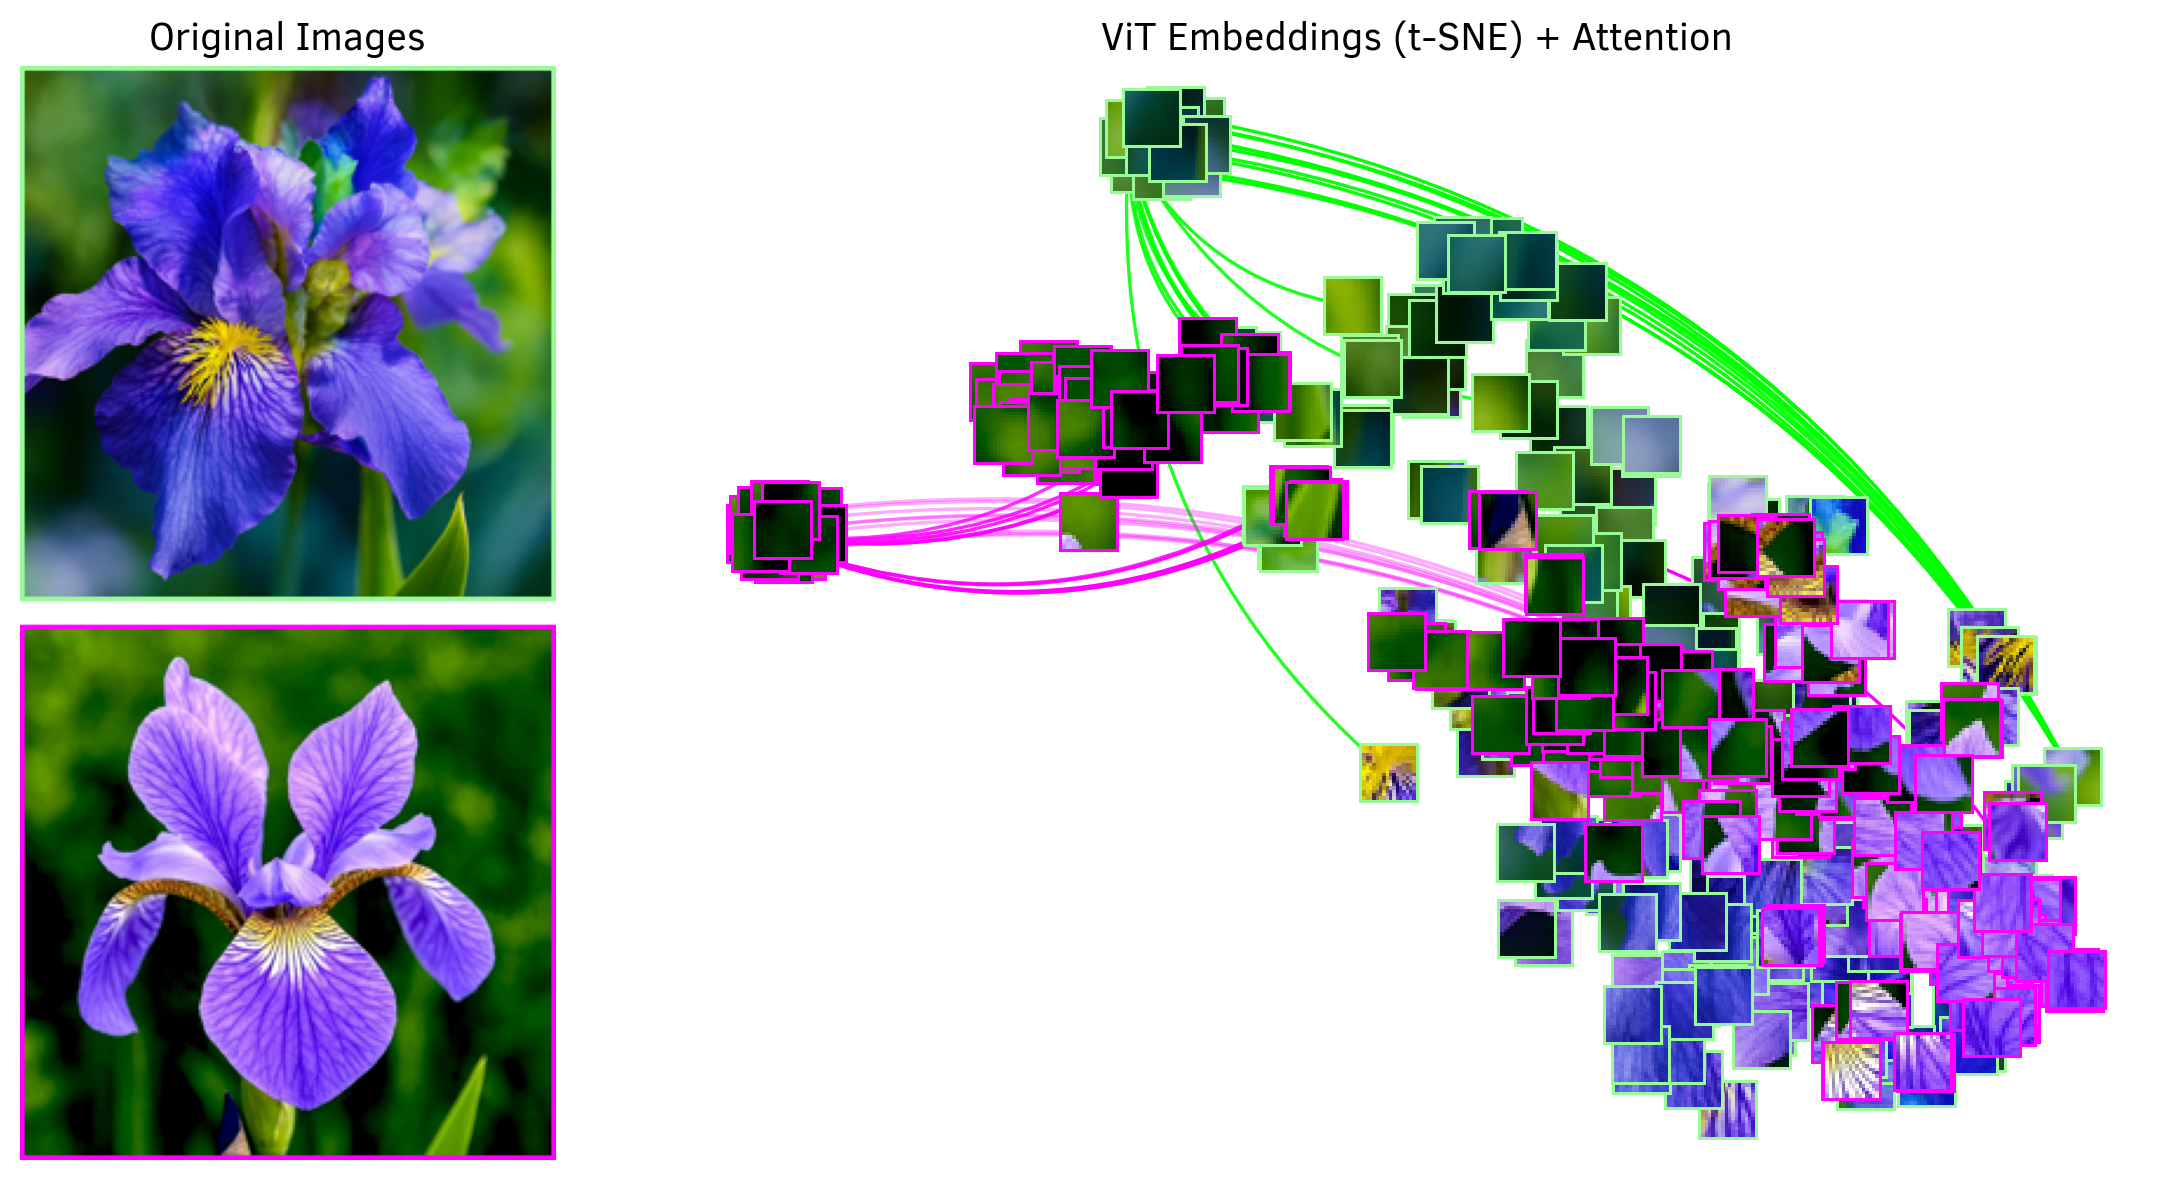

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.manifold import TSNE
from transformers import ViTImageProcessor, ViTModel

# Config
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
IMAGE_PATH1 = "../images/image.png"
IMAGE_PATH2 = "../images/image_2.jpeg"

# Load model and processor
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE).eval()
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

# Load and preprocess images
img1 = Image.open(IMAGE_PATH1).convert("RGB").resize((224, 224))
img2 = Image.open(IMAGE_PATH2).convert("RGB").resize((224, 224))
inputs = processor(images=[img1, img2], return_tensors="pt").to(DEVICE)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

patches1 = outputs.last_hidden_state[0, 1:, :].cpu().numpy()
patches2 = outputs.last_hidden_state[1, 1:, :].cpu().numpy()

# t-SNE
tsne_config = {
    "n_components": 2,
    "perplexity": 30,
    "learning_rate": 200,
    "random_state": 42,
}
proj1 = TSNE(**tsne_config).fit_transform(patches1)
proj2 = TSNE(**tsne_config).fit_transform(patches2)

# Coordinates
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(196)]


# Border function
def add_border(patch: Image.Image, color: str = "blue", thickness: int = 2):
    return ImageOps.expand(patch, border=thickness, fill=color)


# Draw attention from a single token
def draw_attention_from_token(ax, patch_proj, attn_tensor, src_idx, top_k=10, color="crimson"):
    attn = attn_tensor.mean(dim=0)[src_idx + 1, 1:]  # average over heads, skip CLS
    attn_np = attn.cpu().numpy()
    attn_norm = (attn_np - attn_np.min()) / (np.ptp(attn_np) + 1e-8)
    top_indices = np.argsort(attn_np)[-top_k:]
    src_point = patch_proj[src_idx]

    for idx in top_indices:
        if idx == src_idx:
            continue
        dest_point = patch_proj[idx]
        arrow = FancyArrowPatch(
            posA=src_point,
            posB=dest_point,
            arrowstyle="->",
            color=color,
            alpha=attn_norm[idx],
            linewidth=1.2,
            connectionstyle="arc3,rad=0.25",
        )
        ax.add_artist(arrow)


# Plotting
plt.rcParams["font.family"] = "Clear Sans"
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 6), dpi=200, gridspec_kw={"width_ratios": [1, 1.5]}
)

# Left panel: Stacked images
# BACKGROUND_COLOR = "#ffffff"
padding = 10
img1_bordered = add_border(img1, color="palegreen", thickness=2)
img2_bordered = add_border(img2, color="magenta", thickness=2)
combined_img = Image.new(
    "RGB", (img1_bordered.width, img1_bordered.height + img2_bordered.height + padding)
)
combined_img.paste(img1_bordered, (0, 0))
combined_img.paste(img2_bordered, (0, img1_bordered.height + padding))
bg_rgb = tuple(int(BACKGROUND_COLOR.lstrip("#")[i : i + 2], 16) for i in (0, 2, 4))
spacer = Image.new("RGB", (img1_bordered.width, padding), bg_rgb)
combined_img.paste(spacer, (0, img1_bordered.height))

ax1.imshow(combined_img)
ax1.axis("off")
ax1.set_title("Original Images", fontsize=14)

# Right panel: t-SNE and attention
ax2.set_title("ViT Embeddings (t-SNE) + Attention", fontsize=14)
for idx, (x, y) in enumerate(proj1):
    row, col = coords[idx]
    patch = img1.crop(
        (col * patch_size, row * patch_size, (col + 1) * patch_size, (row + 1) * patch_size)
    )
    ab = AnnotationBbox(
        OffsetImage(add_border(patch, "palegreen", 1), zoom=1.2), (x, y), frameon=False
    )
    ax2.add_artist(ab)

for idx, (x, y) in enumerate(proj2):
    row, col = coords[idx]
    patch = img2.crop(
        (col * patch_size, row * patch_size, (col + 1) * patch_size, (row + 1) * patch_size)
    )
    ab = AnnotationBbox(
        OffsetImage(add_border(patch, "magenta", 1), zoom=1.2), (x, y), frameon=False
    )
    ax2.add_artist(ab)

ax2.scatter(proj1[:, 0], proj1[:, 1], c="palegreen", s=10, label="Image 1")
ax2.scatter(proj2[:, 0], proj2[:, 1], c="magenta", s=10, label="Image 2")

# Get attention tensors
attn_img1 = outputs.attentions[-1][0]  # (heads, 197, 197)
attn_img2 = outputs.attentions[-1][1]  # (heads, 197, 197)

pos_idx1 = proj1[:, 0].argmin()
pos_idx2 = proj2[:, 0].argmin()

draw_attention_from_token(ax2, proj1, attn_img1, src_idx=pos_idx1, color="lime")
draw_attention_from_token(ax2, proj2, attn_img2, src_idx=pos_idx2, color="fuchsia")

pos_idx1 = proj1[:, 0].argmax()
pos_idx2 = proj2[:, 0].argmax()

draw_attention_from_token(ax2, proj1, attn_img1, src_idx=pos_idx1, color="lime")
draw_attention_from_token(ax2, proj2, attn_img2, src_idx=pos_idx2, color="fuchsia")

ax2.axis("off")
plt.tight_layout()
plt.savefig(
    "../images/vit_two_images_attention_tsne.png",
    dpi=600,
    bbox_inches="tight",
    facecolor=BACKGROUND_COLOR,
)
plt.show()